<a href="https://colab.research.google.com/github/pavaniroyal66/Recommender-System/blob/main/RecommenderProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install scikit-surprise

# Git Source

In [30]:
!git clone https://github.com/pavaniroyal66/Recommender-System.git

fatal: destination path 'Recommender-System' already exists and is not an empty directory.


In [32]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD,dump,KNNBasic, NMF,KNNWithZScore, KNNWithMeans,SVDpp, SlopeOne, CoClustering, NormalPredictor
from surprise.model_selection import train_test_split, cross_validate,GridSearchCV
from surprise import accuracy
import matplotlib.pyplot as plt


# Data Loading

In [34]:
ratings_cols = ['user id', 'movie id', 'rating', 'timestamp']
ratings_df = pd.read_csv('/content/Recommender-System/u.data', sep='\t', names=ratings_cols)

# Loading u.item (movie information) dataset
movies_cols = ['movie id', 'movie title', 'release date', 'video release date', 'IMDb URL',
               'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy',
               'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
               'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies_df = pd.read_csv('/content/Recommender-System/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Loading u.user (user information) dataset
users_cols = ['user id', 'age', 'gender', 'occupation', 'zip code']
users_df = pd.read_csv('/content/Recommender-System/u.user', sep='|', names=users_cols)

In [36]:
ratings_df.head()

,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [38]:
movies_df.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [40]:
users_df.head()

,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [42]:
merged_df = ratings_df[['user id', 'movie id', 'rating']].merge(movies_df[['movie id', 'movie title', 'Action', 'Adventure', 'Animation', 'Children\'s',
                                        'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
                                        'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']],
                             left_on='movie id', right_on='movie id')

merged_df = merged_df.merge(users_df[['user id', 'age', 'gender', 'occupation']], on='user id')


In [44]:
merged_df.head()

,user id,movie id,rating,movie title,Action,Adventure,Animation,Children's,Comedy,Crime,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,age,gender,occupation
0,196,242,3,Kolya (1996),0,0,0,0,1,0,...,0,0,0,0,0,0,0,49,M,writer
1,196,257,2,Men in Black (1997),1,1,0,0,1,0,...,0,0,0,1,0,0,0,49,M,writer
2,196,111,4,"Truth About Cats & Dogs, The (1996)",0,0,0,0,1,0,...,0,0,1,0,0,0,0,49,M,writer
3,196,25,4,"Birdcage, The (1996)",0,0,0,0,1,0,...,0,0,0,0,0,0,0,49,M,writer
4,196,382,4,"Adventures of Priscilla, Queen of the Desert, ...",0,0,0,0,1,0,...,0,0,0,0,0,0,0,49,M,writer


# EDA

In [46]:
merged_df.isnull().sum()

user id        0
movie id       0
rating         0
movie title    0
Action         0
Adventure      0
Animation      0
Children's     0
Comedy         0
Crime          0
Documentary    0
Drama          0
Fantasy        0
Film-Noir      0
Horror         0
Musical        0
Mystery        0
Romance        0
Sci-Fi         0
Thriller       0
War            0
Western        0
age            0
gender         0
occupation     0
dtype: int64

In [48]:
print('Total distinct Users : {}'.format(len(merged_df['user id'].unique())))
print('Total distinct Movies : {}'.format(len(merged_df['movie id'].unique())))
print('Total ratings : {}'.format(len(merged_df)))
print('distinct Ratings: {}'.format(sorted(merged_df['rating'].unique())))

Total distinct Users : 943
Total distinct Movies : 1682
Total ratings : 100000
distinct Ratings: [1, 2, 3, 4, 5]


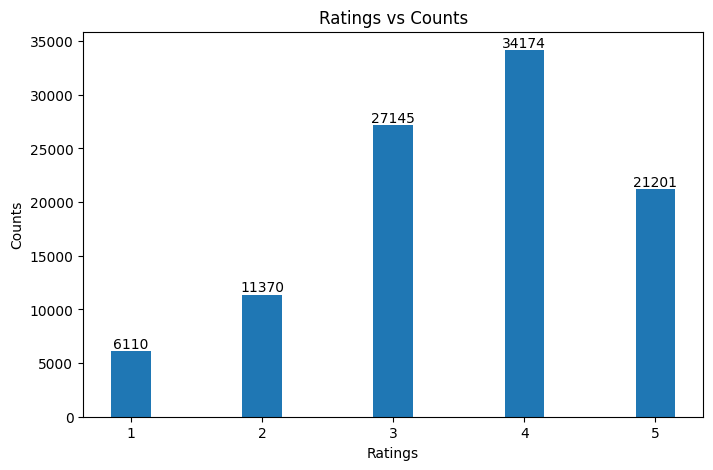

In [50]:
plt.figure(figsize=(8, 5))
ratings_df = merged_df.groupby(by=['rating']).agg({'user id': 'count'}).rename(columns={'user id': 'count'}).reset_index()
bars = plt.bar(ratings_df['rating'], ratings_df['count'], align='center', width=0.3)


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

plt.xticks(ratings_df['rating'])
plt.title("Ratings vs Counts")
plt.xlabel("Ratings")
plt.ylabel("Counts")
plt.show()

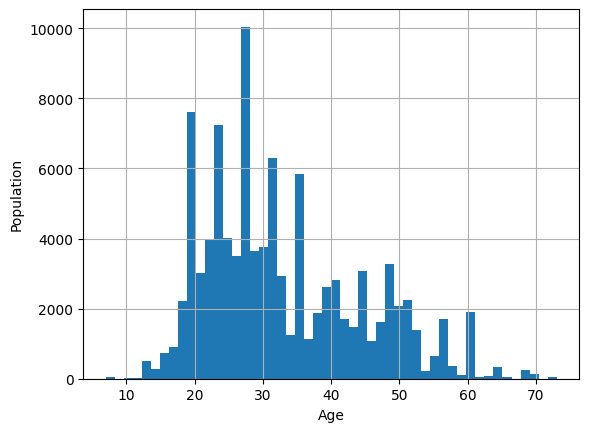

In [52]:
merged_df['age'].hist(bins=50)
plt.xlabel('Age')
plt.ylabel('Population')
plt.show()

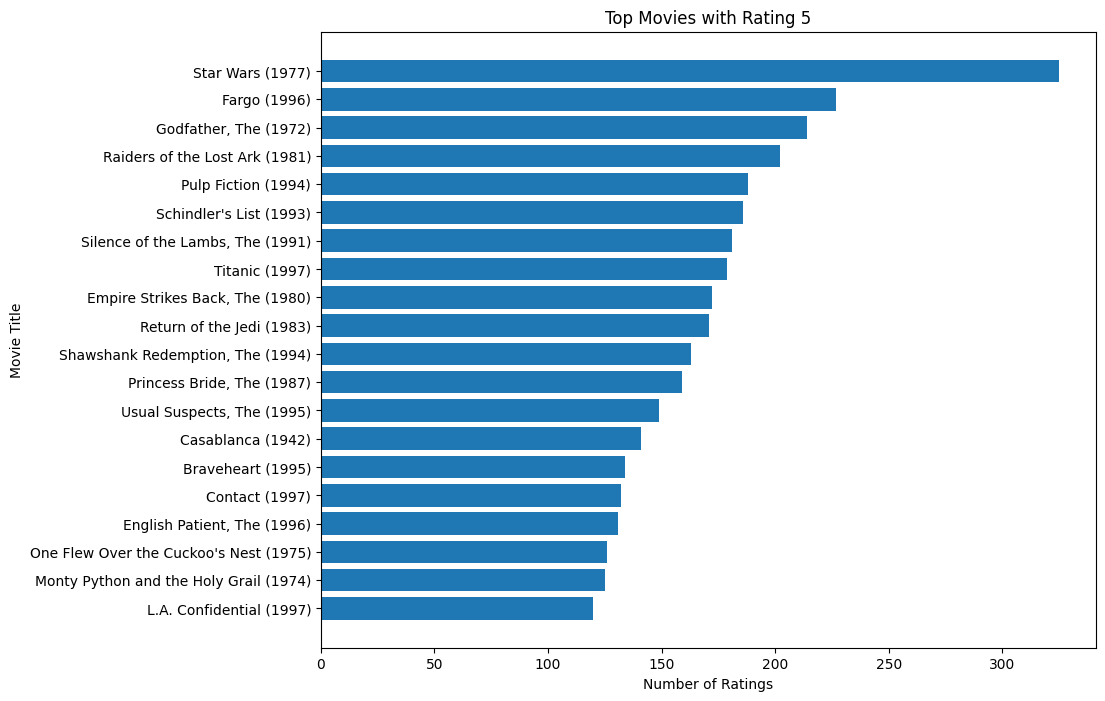

In [54]:
high_rating_movies = merged_df[merged_df['rating'] == 5]
unique_movies, counts = np.unique(high_rating_movies['movie title'], return_counts=True)
# Sorting unique_movies based on counts in descending order
sorted_indices = np.argsort(counts)[::-1]
sorted_movies = unique_movies[sorted_indices]
sorted_counts = counts[sorted_indices]

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(sorted_movies[:20], sorted_counts[:20])
plt.title('Top Movies with Rating 5')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.gca().invert_yaxis()
plt.show()

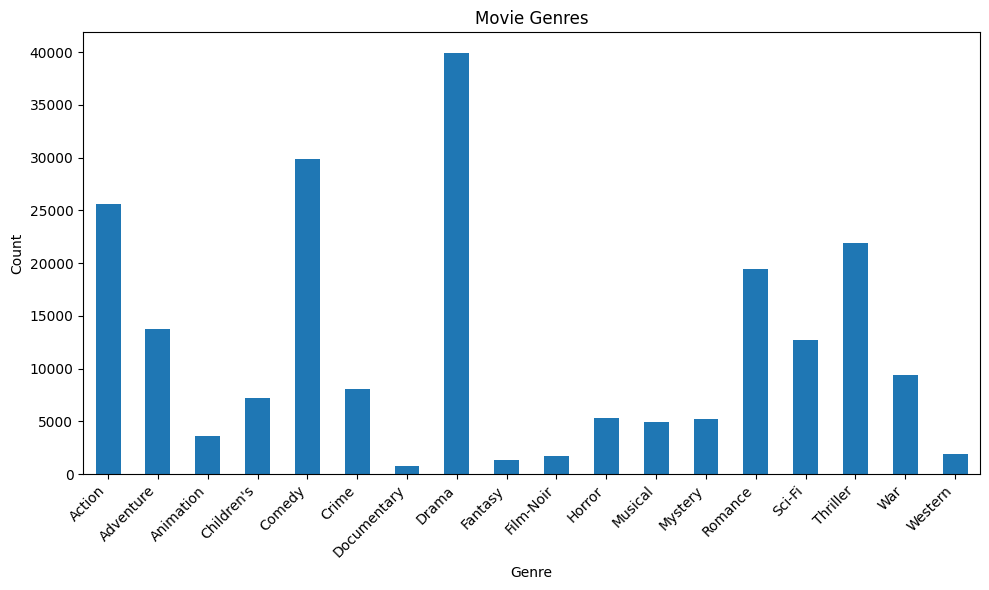

In [56]:
genre_counts = merged_df.iloc[:, 4:-3].sum()

plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Movie Genres')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Pivot Matrix

In [58]:
# Pivot Matrix
movie_rating_by_user=merged_df.pivot_table(index='movie title',columns='user id',values='rating').fillna(0)
movie_rating_by_user.head()

user id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
movie title,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1-900 (1994),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101 Dalmatians (1996),2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0
12 Angry Men (1957),5.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187 (1997),0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Algorithms Implementation

In [60]:
# Preparing data for Surprise library
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(merged_df[['user id', 'movie id', 'rating',]], reader)

In [62]:
trainset, testset = train_test_split(data, test_size=0.2)

In [64]:
# Defining algorithms
algos = {
    "SVD": SVD(),
    "SVD++": SVDpp(),
    "NMF": NMF(),
    "SlopeOne": SlopeOne(),
    "KNNBasic": KNNBasic()
}

# Performing cross-validation for each algorithm
for algo_name, algo in algos.items():
    print(f"Evaluating {algo_name}...")
    algo.fit(trainset)
    # Predicting ratings
    predictions = algo.test(testset)
    # Model performance evaluate
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)
    print(f"RMSE: {rmse} & MAE: {mae}")
    print()

Evaluating SVD...
RMSE: 0.9382
MAE:  0.7385
RMSE: 0.9382086922523594 & MAE: 0.7384902546619991

Evaluating SVD++...
RMSE: 0.9188
MAE:  0.7218
RMSE: 0.9188191572923251 & MAE: 0.7218233706993248

Evaluating NMF...
RMSE: 0.9600
MAE:  0.7539
RMSE: 0.9600295482489334 & MAE: 0.7538844467921714

Evaluating SlopeOne...
RMSE: 0.9453
MAE:  0.7431
RMSE: 0.9452644691141975 & MAE: 0.743101003724443

Evaluating KNNBasic...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9787
MAE:  0.7723
RMSE: 0.9787021109688331 & MAE: 0.7723286499758413



# Cross Validation

In [66]:
cross_validate(SVD(),data,measures=['RMSE','MAE'],cv=5,verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9405  0.9378  0.9319  0.9278  0.9410  0.9358  0.0052  
MAE (testset)     0.7416  0.7387  0.7341  0.7323  0.7404  0.7374  0.0036  
Fit time          0.88    0.95    0.99    0.96    0.91    0.94    0.04    
Test time         0.28    0.10    0.11    0.28    0.11    0.18    0.09    


{'test_rmse': array([0.94048141, 0.93780211, 0.93186159, 0.92779792, 0.94104403]),
 'test_mae': array([0.74160681, 0.73865201, 0.7340719 , 0.73231126, 0.74044127]),
 'fit_time': (0.8836240768432617,
  0.9487342834472656,
  0.9914281368255615,
  0.9563872814178467,
  0.9062013626098633),
 'test_time': (0.2787301540374756,
  0.09678053855895996,
  0.10833215713500977,
  0.27976059913635254,
  0.11260795593261719)}

# GridSearchCV

In [21]:
params = { "n_epochs":range(10,110,10), "lr_all":[0.002, 0.005,0.01, 0.02], "reg_all":[0.02, 0.4, 0.6,0.1, 0.2, 0.5] }
grid_search = GridSearchCV(SVD, params, measures=["rmse", "mae"], refit=True, cv=5)
grid_search.fit(data)

training_parameters = grid_search.best_params["rmse"]
print("BEST RMSE: \t", grid_search.best_score["rmse"])
print("BEST params: \t", grid_search.best_params["rmse"])

BEST RMSE: 	 0.9085828643729827
BEST params: 	 {'n_epochs': 100, 'lr_all': 0.005, 'reg_all': 0.1}


# Parameter Tuning

In [22]:
from collections import defaultdict

def precision_recall_calculation(predictions, threshold=3):
    user_predict_true = defaultdict(list)
    for user_id, _, true_rating, predicted_rating, _ in predictions:
        user_predict_true[user_id].append((predicted_rating, true_rating))

    precisions = []
    recalls = []
    for user_id, user_ratings in user_predict_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        num_relevant_items = sum(true_rating >= threshold for predicted_rating, true_rating in user_ratings)
        num_recommended_items = min(10, len(user_ratings))
        num_relevant_and_recommended_items = sum(true_rating >= threshold for predicted_rating, true_rating in user_ratings[:10])
        precisions.append(num_relevant_and_recommended_items / num_recommended_items if num_recommended_items != 0 else 1)
        recalls.append(num_relevant_and_recommended_items / num_relevant_items if num_relevant_items != 0 else 1)

    average_precision = sum(precisions) / len(precisions)
    average_recall = sum(recalls) / len(recalls)
    f_score = (2 * average_precision * average_recall) / (average_precision + average_recall)

    return average_precision, average_recall, f_score

In [23]:
svd=SVD(n_epochs=training_parameters['n_epochs'], lr_all=training_parameters['lr_all'], reg_all=training_parameters['reg_all'])
svd.fit(trainset)

In [24]:
# Predicting on the test dataset
test_set_predicted = svd.test(testset)
print("Deviation RMSE: {}".format(accuracy.rmse(test_set_predicted, verbose=False)))
print("Deviation MAE: \t{}".format(accuracy.mae(test_set_predicted, verbose=False)))
precision, recall, F_score = precision_recall_calculation(test_set_predicted, threshold=3)
print("Precision: \t{}".format(precision))
print("Recall: \t{}".format(recall))
print("F_score: \t{}".format(F_score))

Deviation RMSE: 0.9101038534283518
Deviation MAE: 	0.7182022058354857
Precision: 	0.8903953870105232
Recall: 	0.6960416056586896
F_score: 	0.7813133931063333


# Overall Performance

In [25]:
result = pd.DataFrame(test_set_predicted, columns=['UserId', 'MovieId', 'Rating', 'est', 'details'])
result['est'] = result['est'].round(decimals=1)
result['est'] = result['est'].round()
result['error'] = abs(result.est - result.Rating)
display(result.sort_values(by='error', ascending=True))

,UserId,MovieId,Rating,est,details,error
0,821,294,4.0,4.0,{'was_impossible': False},0.0
10543,871,690,3.0,3.0,{'was_impossible': False},0.0
10549,474,923,4.0,4.0,{'was_impossible': False},0.0
10554,153,294,2.0,2.0,{'was_impossible': False},0.0
10555,43,69,4.0,4.0,{'was_impossible': False},0.0
...,...,...,...,...,...,...
16755,943,549,1.0,4.0,{'was_impossible': False},3.0
12890,671,222,1.0,4.0,{'was_impossible': False},3.0
10616,551,765,1.0,4.0,{'was_impossible': False},3.0
11617,919,168,1.0,4.0,{'was_impossible': False},3.0


In [26]:
print("Accuracy = {} %".format(100-round((result[result['error']>=1].shape[0]/result.shape[0]),2)))

Accuracy = 99.42 %


# Model Performances

In [27]:
rows = []
algorithms = [SVD(), SVDpp(), NMF(),SlopeOne(), KNNBasic()]

for algorithm in algorithms:
    avg_dict = {}
    algorithm_name = str(algorithm).split(' ')[0].split('.')[-1]
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
    for k, v in results.items():
      avg_dict[k] = sum(v)/ float(len(v))
    rows.append([algorithm_name, avg_dict['test_rmse'], avg_dict['test_mae'], avg_dict['fit_time'], avg_dict['test_time']])

benchmarks_df = pd.DataFrame(rows, columns=['Algorithm', 'test_rmse', 'test_mae', 'fit_time', 'test_time'])
display(benchmarks_df)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,Algorithm,test_rmse,test_mae,fit_time,test_time
0,SVD,0.936937,0.738140,0.882483,0.134404
1,SVDpp,0.919506,0.722190,21.990247,3.635686
2,NMF,0.961300,0.756005,1.247864,0.136324
3,SlopeOne,0.944499,0.742251,0.501086,1.792542
4,KNNBasic,0.978844,0.773058,0.232927,2.584687


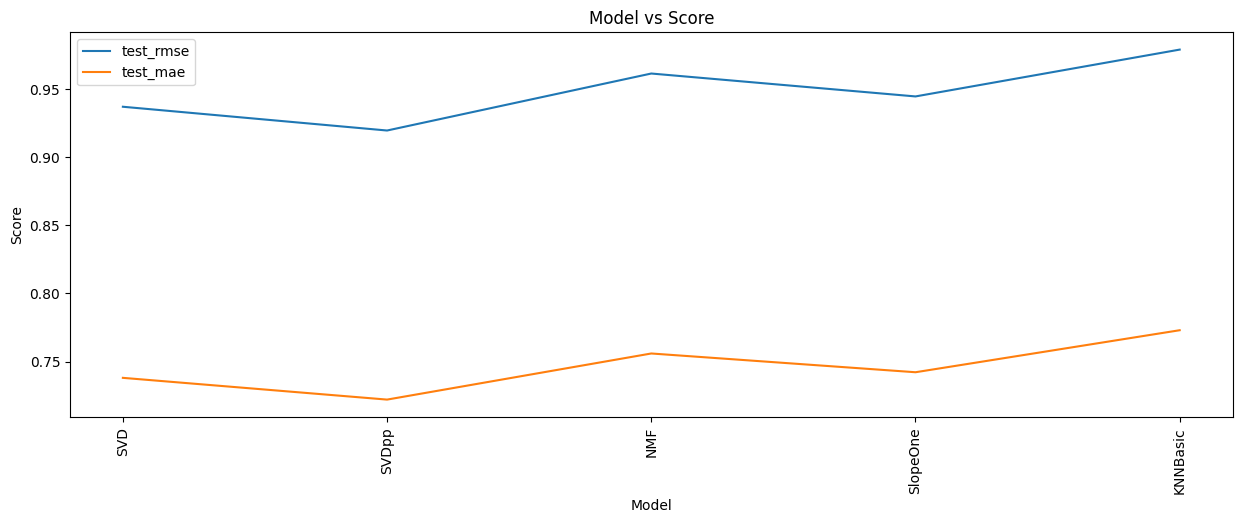

In [28]:
fig, ax = plt.subplots(1,1);
benchmarks_df.plot(kind="line", x="Algorithm", y="test_rmse", title="Model vs Score", ax=ax, figsize=(15, 5), xlabel="Model", ylabel="Score")
benchmarks_df.plot(kind="line", x="Algorithm", y="test_mae", title="Model vs Score",  ax=ax, figsize=(15, 5), xlabel="Model", ylabel="Score")
plt.xticks(benchmarks_df.index, benchmarks_df['Algorithm'], rotation=90)
for line in ax.lines:
    line.set_linewidth(1.5)